In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [3]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")

Using device : cuda


In [4]:
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fmnist_small.csv")

In [5]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,...,pixel735,pixel736,pixel737,pixel738,pixel739,pixel740,pixel741,pixel742,pixel743,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,72,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,120,108,0,0,4,6,11,...,243,255,255,251,242,236,230,246,228,0,0,3,0,2,0,0,210,228,228,233,0,0,0,0,0,0,0,0,0,31,81,133,184,201,190,117,0,0,2,1,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,43,117,34,15,24,33,117,80,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,51,144,152,202,213,210,205,204,221,157,172,131,55,...,0,77,157,148,155,146,151,149,152,154,157,158,161,148,159,58,0,6,0,0,0,0,0,0,0,0,0,4,0,60,143,143,148,146,152,152,148,148,147,145,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,0,0,0,2,0,33,114,37,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,47,136,31,136,42,0,3,0,...,138,152,160,152,162,144,208,181,1,18,11,17,13,13,11,10,7,5,5,5,7,0,0,0,1,0,0,41,69,88,86,94,106,114,118,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,0,2,0,58,145,114,10,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,29,132,0,0,101,10,0,2,0,0,...,155,178,149,163,165,138,147,170,149,134,165,153,155,134,143,172,215,62,0,0,0,0,0,0,0,0,10,190,178,194,209,211,209,205,211,215,213,217,225,228,213,203,174,151,188,10,0,0,0,0


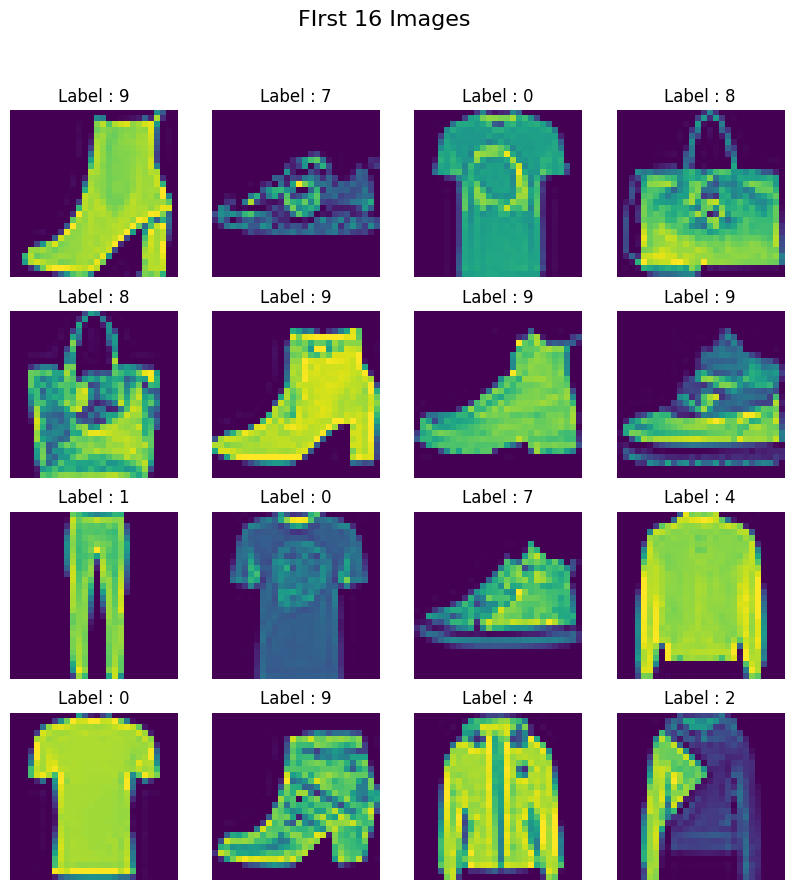

In [6]:
fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle("FIrst 16 Images",fontsize=16)
for i,ax in enumerate(axes.flat):
  img=df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label : {df.iloc[i,0]}")

plt.show()

In [9]:
X=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [10]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [11]:
X_train=X_train/255.0
X_test=X_test/255.0

In [12]:
class CustomDataset(Dataset):
  def __init__(self,features,labels):
    self.features=torch.tensor(features,dtype=torch.float32).reshape(-1,1,28,28)
    self.labels=torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index],self.labels[index]

In [13]:
train_dataset=CustomDataset(X_train,y_train)
test_dataset=CustomDataset(X_test,y_test)

In [14]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [20]:
class MyNN(nn.Module):
  def __init__(self,input_features):
    super().__init__()

    self.features=nn.Sequential(
        nn.Conv2d(input_features,32,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(32,64,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2,stride=2),

    )

    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*7*7,128),
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(64,10)
    )

  def forward(self,x):
    x=self.features(x)
    x=self.classifier(x)

    return x

In [16]:
learning_rate=0.01
epochs=100

In [21]:
model=MyNN(1)

model.to(device)

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)

In [22]:
for epoch in range(epochs):
  total_epoch_loss=0
  for batch_features,batch_labels in train_loader:
    # move data to gpu
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    # forward pass
    outputs=model(batch_features)
    # calculate loss
    loss=criterion(outputs,batch_labels)
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    #update grads
    optimizer.step()

    total_epoch_loss+=loss.item()
  avg_loss=total_epoch_loss/len(train_loader)
  print(f"Epoch : {epoch+1}/{epochs} Loss : {avg_loss:.4f}")

Epoch : 1/100 Loss : 1.5442
Epoch : 2/100 Loss : 0.8726
Epoch : 3/100 Loss : 0.6996
Epoch : 4/100 Loss : 0.6056
Epoch : 5/100 Loss : 0.5368
Epoch : 6/100 Loss : 0.4806
Epoch : 7/100 Loss : 0.4366
Epoch : 8/100 Loss : 0.3819
Epoch : 9/100 Loss : 0.3520
Epoch : 10/100 Loss : 0.3327
Epoch : 11/100 Loss : 0.2948
Epoch : 12/100 Loss : 0.2866
Epoch : 13/100 Loss : 0.2534
Epoch : 14/100 Loss : 0.2181
Epoch : 15/100 Loss : 0.2136
Epoch : 16/100 Loss : 0.1837
Epoch : 17/100 Loss : 0.1728
Epoch : 18/100 Loss : 0.1473
Epoch : 19/100 Loss : 0.1408
Epoch : 20/100 Loss : 0.1203
Epoch : 21/100 Loss : 0.1196
Epoch : 22/100 Loss : 0.1077
Epoch : 23/100 Loss : 0.1051
Epoch : 24/100 Loss : 0.0826
Epoch : 25/100 Loss : 0.0816
Epoch : 26/100 Loss : 0.0826
Epoch : 27/100 Loss : 0.0754
Epoch : 28/100 Loss : 0.0608
Epoch : 29/100 Loss : 0.0673
Epoch : 30/100 Loss : 0.0520
Epoch : 31/100 Loss : 0.0531
Epoch : 32/100 Loss : 0.0433
Epoch : 33/100 Loss : 0.0509
Epoch : 34/100 Loss : 0.0422
Epoch : 35/100 Loss : 0

In [23]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [24]:
total=0
correct=0

with torch.no_grad():
  for batch_features,batch_labels in test_loader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

    outputs=model(batch_features)

    _,predicted=torch.max(outputs,1)

    total=total+batch_labels.shape[0]

    correct=correct+(predicted==batch_labels).sum().item()

accuracy=correct/total
print(accuracy)


0.875


In [25]:
total=0
correct=0

with torch.no_grad():
  for batch_features,batch_labels in train_loader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

    outputs=model(batch_features)

    _,predicted=torch.max(outputs,1)

    total=total+batch_labels.shape[0]

    correct=correct+(predicted==batch_labels).sum().item()

accuracy=correct/total
print(accuracy)


1.0
